# Using Quality Flags to Create and Utilize Annotations

OOI utilizes the SAMI2-pH sensor from [Sunburst Sensors, LLC](http://www.sunburstsensors.com/) to measure seawater pH at multiple locations throughout the different arrays. Assessing the quality of the data from the instrument is an involved process as there are multiple parameters produced by the instrument that are then used to calculate the seawater pH. These different measurements are subject to different sources of error, and those errors can propogate through the calculations to create an erroneous seawater pH value. Based upon the vendor documentation and Matlab code they provide to convert the raw measurements, we can create [a set of rules](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/ooi_data_explorations/uncabled/process_phsen.py#L152) from those different measurements to flag the pH data as either `pass`, `suspect` or `fail` (using the QARTOD flag values of 1, 3 and 4, respectively).

The resulting flags can be used to remove `fail` data from any analysis. They can also be used to help generate annotations that can be used during further Human in the Loop (HITL) QC checks of the data to help refine quality metrics for the data. The code below will show how the quality rules can be used to remove bad pH data from a time series, and how they can be used to then create annotations. The impact of using these flags is shown with a set of before and after plots of the seawater pH as a function of temperature.

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd

from ooi_data_explorations.common import get_annotations, load_gc_thredds, add_annotation_qc_flags
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.uncabled.process_phsen import phsen_datalogger, phsen_instrument, quality_checks
from ooi_data_explorations.qartod.qc_processing import identify_blocks, create_annotations, \
    process_gross_range, process_climatology

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

## Oregon Inshore Midwater Platform

Data from a pH sensor on the Oregon Inshore Surface Mooring (CE01ISSM) midwater platform (aka the Near Surface Instrument Frame, NSIF), deployed at 7 m depth (site depth is 25 m) is used for this analysis. Initially we are going to look at the telemetered data from Deployment 2 (October 2014 through April 2015).

In [2]:
# setup the request parameters to download the data from the M2M system
site = 'CE01ISSM'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '06-PHSEND000'     # OOI Net sensor designator
method = 'telemetered'      # OOI Data delivery method
stream = 'phsen_abcdef_dcl_instrument'   # OOI data set (stream) name 
tag = '.*deployment0002.*PHSEN.*\\.nc$'  # limit request to PHSEN NetCDF files from Deployment 2

# download the data from the OOI Gold Copy THREDDS server
data = load_gc_thredds(site, node, sensor, method, stream, tag)

# re-organize and rename the variables and add the quality checks
phsen = phsen_datalogger(data)

Waiting: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Part of the `phsen_datalogger` module (imported above, and used to reorganize and restructure the data downloaded from OOI into a more useful form) is a function to assess the data quality. This function, called `quality_checks`, looks at select parameters (signal and reference channels) used to calculate the seawater pH and sets a QARTOD style quality flag for each data point. We can use the quality flags to quickly highlight data marked as `fail`, as in the plot below

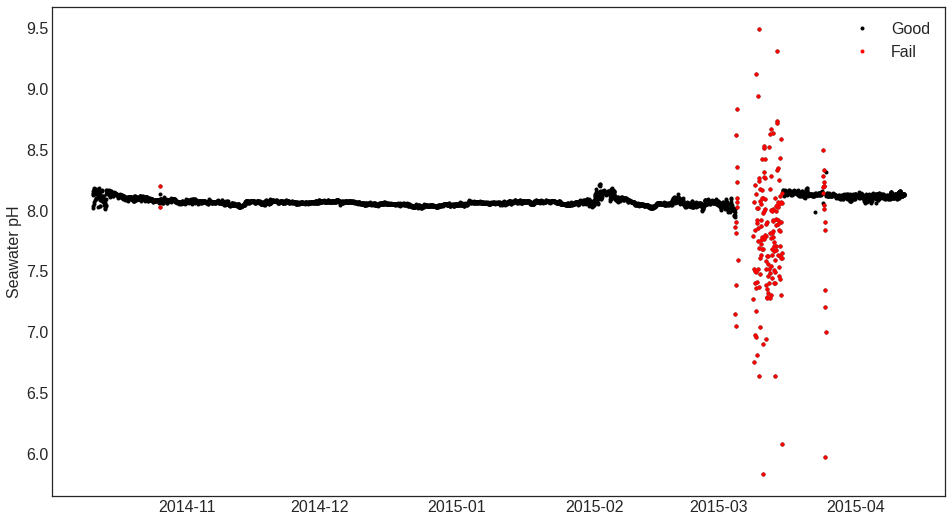

In [3]:
# plot the seawater pH values highlighting the "bad" data as defined by the quality checks
bad = phsen.where(phsen.seawater_ph_quality_flag==4)
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.plot(phsen['time'], phsen['seawater_ph'], '.k', label='Good')
plt.plot(bad['time'], bad['seawater_ph'], '.r', label='Fail')
plt.ylabel('Seawater pH')
plt.legend()

Once we have created a time series of quality flags, we can take those a step further and use them to identify blocks, or groupings, of the `fail` data that can be used to generate an intial set of annotations for further Human in the Loop (HITL) reviews of the data. By blocks, we mean a semi-continuous period of time where consecutive data points are flagged as `fail`. Points are defined as consecutive if they occur within a certain time range of the preceding flagged point. This helps to eliminate times when the data is noisy and the flagging is inconsistent. 

For the annotations, we are interested in periods of time where the duration of bad data points exceeds 24 hours, and there is more than 24 hours of time between each block (if not, the next set of bad points are added to the preceding block). The functions used to identify the blocks and then create the annotations are included in the `qc_processing` module (imported above).

In [6]:
# create a boolean array of the quality flag for just the failed data
fail = phsen.seawater_ph_quality_flag.where(phsen.seawater_ph_quality_flag==4).notnull()

# identify blocks of failed data points
blocks = identify_blocks(fail, [24, 24])

# use the identified blocks of data marked as "fail" to create initial HITL annotations for the pH data
hitl = create_annotations(site, node, sensor, blocks)
hitl

{'id': [''],
 'subsite': ['CE01ISSM'],
 'node': ['RID16'],
 'sensor': ['06-PHSEND000'],
 'method': [None],
 'stream': [None],
 'parameters': [[]],
 'beginDT': [1425501193000],
 'beginDate': ['2015-03-04T20:33:13'],
 'endDT': [1426419202000],
 'endDate': ['2015-03-15T11:33:22'],
 'exclusionFlag': ['False'],
 'qcFlag': ['fail'],
 'source': ['replace.me@whatever.com'],
 'annotation': ['Based on a HITL review and automated quality assessments of the data, the data highlighted during this time period is considered inaccurate and users should avoid using the data as part of any analysis.']}

The above example works for just one deployment from back in 2015, but there have been several more since then. We can download all the pH data recorded from the Oregon Inshore Surface Mooring midwater platform from the different data delivery methods (helps to fill in gaps if telemetry or instrument data logging failed), merge the different data sets into a single record, create quality flags, and create initial HITL annotations for the entire record through the present.

In [7]:
# set a regex tag to limit the data download to just the PHSEN data for all deployments
tag = '.*PHSEN.*\\.nc$'

# download the telemetered data and re-process it to create a more useful and coherent data set
telem = load_gc_thredds(site, node, sensor, 'telemetered', 'phsen_abcdef_dcl_instrument', tag)
telem = phsen_datalogger(telem)

# download the recovered host data and re-process it to create a more useful and coherent data set
rhost = load_gc_thredds(site, node, sensor, 'recovered_host', 'phsen_abcdef_dcl_instrument_recovered', tag)
rhost = phsen_datalogger(rhost)

# download the recovered instrument data and re-process it to create a more useful and coherent data set
rinst = load_gc_thredds(site, node, sensor, 'recovered_inst', 'phsen_abcdef_instrument', tag)
rinst = phsen_instrument(rinst)

# combine the three datasets into a single, merged time series, resampled to a 3 hour interval time series
merged = combine_datasets(telem, rhost, rinst, 180)

# re-run the quality checks, since averaging will change the flag values
merged['seawater_ph_quality_flag'] = quality_checks(merged)

Waiting: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


In [14]:
# Create the HITL annotations for the entire record and convert them into a pandas dataframe
fail = merged.seawater_ph_quality_flag.where(merged.seawater_ph_quality_flag==4).notnull()
blocks = identify_blocks(fail, [24, 24])
hitl = create_annotations(site, node, sensor, blocks)
hitl = pd.DataFrame(hitl)
hitl

,id,subsite,node,sensor,method,stream,parameters,beginDT,beginDate,endDT,endDate,exclusionFlag,qcFlag,source,annotation
0,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1397768400000,2014-04-17T21:00:00,1412953200000,2014-10-10T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
1,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1425502800000,2015-03-04T21:00:00,1426420800000,2015-03-15T12:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
2,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1428807600000,2015-04-12T03:00:00,1433343600000,2015-06-03T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
3,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1444186800000,2015-10-07T03:00:00,1444327200000,2015-10-08T18:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
4,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1454295600000,2016-02-01T03:00:00,1463583600000,2016-05-18T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
5,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1488218400000,2017-02-27T18:00:00,1490605200000,2017-03-27T09:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
6,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1492462800000,2017-04-17T21:00:00,1492570800000,2017-04-19T03:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
7,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1502150400000,2017-08-08T00:00:00,1502798400000,2017-08-15T12:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
8,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1503262800000,2017-08-20T21:00:00,1503414000000,2017-08-22T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
9,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1504504800000,2017-09-04T06:00:00,1507831200000,2017-10-12T18:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...


We now have record of 6+ years worth of data, with most of the bad data identified and initial HITL annotations with which to work. We can download the existing annotations from the system and combine them with the ones just created. Outside of this notebook, then, the next step would be to save these combined annotations and use them to review the data in much greater depth to confirm the quality flags and the indentified blocks. This would be the HITL process. Rather than saving and reviewing them, for the purposes of this notebook, we'll just display and use them as-is.

In [16]:
# get the current system annotations for the sensor
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
annotations = annotations.drop(columns=['@class'])
annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

# append the fail annotations to the existing annotations
annotations = annotations.append(hitl, ignore_index=True)

# set the annotation column orders
header_names = ['id', 'subsite', 'node', 'sensor', 'method', 'stream', 'parameters', 
                'beginDT', 'beginDate', 'endDT', 'endDate', 'exclusionFlag', 'qcFlag', 'source', 'annotation']
annotations = annotations.reindex(columns=header_names)
annotations

,id,subsite,node,sensor,method,stream,parameters,beginDT,beginDate,endDT,endDate,exclusionFlag,qcFlag,source,annotation
0,1697,CE01ISSM,RID16,06-PHSEND000,None,None,[],1560643200000,2019-06-16T00:00:00,1571788620000,2019-10-22T23:57:00,False,suspect,wingardc@oregonstate.edu,Data indicates the sensor has either fouled or...
1,2342,CE01ISSM,None,None,recovered_host,None,[],1485949200000,2017-02-01T11:40:00,1492458300000,2017-04-17T19:45:00,False,not_operational,wingardc@oregonstate.edu,The buoy and mfn battery voltages have been dr...
2,1893,CE01ISSM,RID16,None,None,None,[],1578768300000,2020-01-11T18:45:00,1594656000000,2020-07-13T16:00:00,False,not_operational,wingardc@oregonstate.edu,"During a large storm event on 2020-01-11, the ..."
3,2594,CE01ISSM,None,None,telemetered,None,[],1551875700000,2019-03-06T12:35:00,1556381040000,2019-04-27T16:04:00,False,not_operational,kuebelb@oregonstate.edu,The buoy battery voltage has been drawn down f...
4,871,CE01ISSM,None,None,telemetered,None,[],1485949200000,2017-02-01T11:40:00,1492458300000,2017-04-17T19:45:00,False,not_operational,michaesm@marine.rutgers.edu,The buoy and mfn battery voltages have been dr...
5,868,CE01ISSM,None,None,telemetered,None,[],1397767500000,2014-04-17T20:45:00,1408228200000,2014-08-16T22:30:00,False,not_available,michaesm@marine.rutgers.edu,"Due to a bug in the mooring telemetry code, a ..."
6,869,CE01ISSM,None,None,telemetered,None,[],1470692700000,2016-08-08T21:45:00,1475439300000,2016-10-02T20:15:00,False,not_operational,michaesm@marine.rutgers.edu,The buoy and mfn battery voltages have been dr...
7,2595,CE01ISSM,None,None,recovered-host,None,[],1551875700000,2019-03-06T12:35:00,1556381040000,2019-04-27T16:04:00,False,not_operational,kuebelb@oregonstate.edu,The buoy battery voltage has been drawn down f...
8,2602,CE01ISSM,None,None,telemetered,None,[],1440452400000,2015-08-24T21:40:00,1444176000000,2015-10-07T00:00:00,False,not_available,wingardc@oregonstate.edu,"The DSL modem, which acts as an Ethernet switc..."
9,2685,CE01ISSM,RID16,None,telemetered,None,[],1612788000000,2021-02-08T12:40:00,1616950800000,2021-03-28T17:00:00,False,not_operational,wingardc@oregonstate.edu,"Due to the extended length of the deployment, ..."


An additional function in the `common` module, called `add_annotation_qc_flags` can be used to add the annotations from above into the data set using a QARTOD flag value to represent the annotations qcFlag value. Those annotation flags, and the quality flags created above, can be used to create a final, cleaned up data set.

In [18]:
# use the annotation blocks created created above and merged with the existing system 
# annotations to create an annotation based QC flag.
merged = add_annotation_qc_flags(merged, annotations)

# create a "good" dataset excluding data marked as "fail" either from the quality checks or the annotations
good = merged.where((merged.seawater_ph_quality_flag != 4) & (merged.rollup_annotations_qc_results != 4))

Now we can take a look at how we've done.

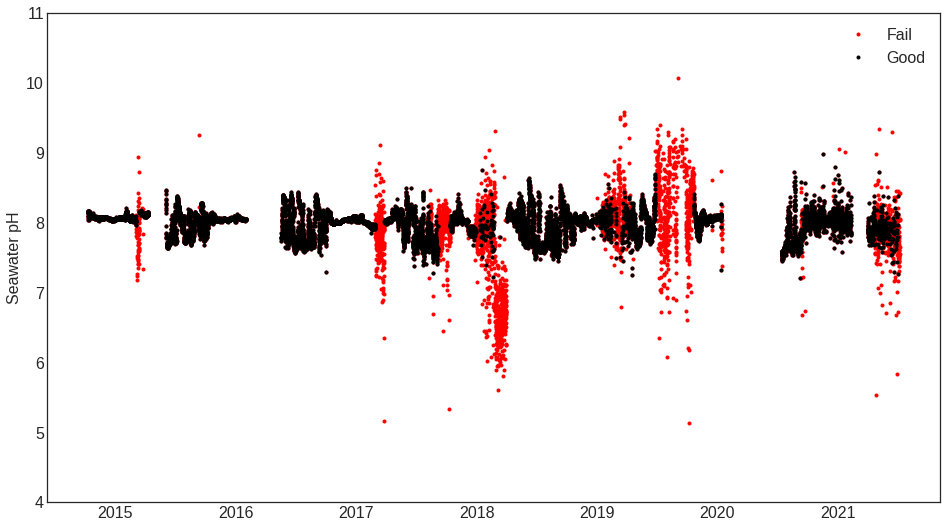

In [19]:
# plot the 6+ years of seawater pH values highlighting the "fail" data as defined by the quality checks
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.plot(merged['time'], merged['seawater_ph'], '.r', label='Fail')
plt.plot(good['time'], good['seawater_ph'], '.k', label='Good')
plt.ylabel('Seawater pH')
plt.ylim(4, 11)
plt.legend()

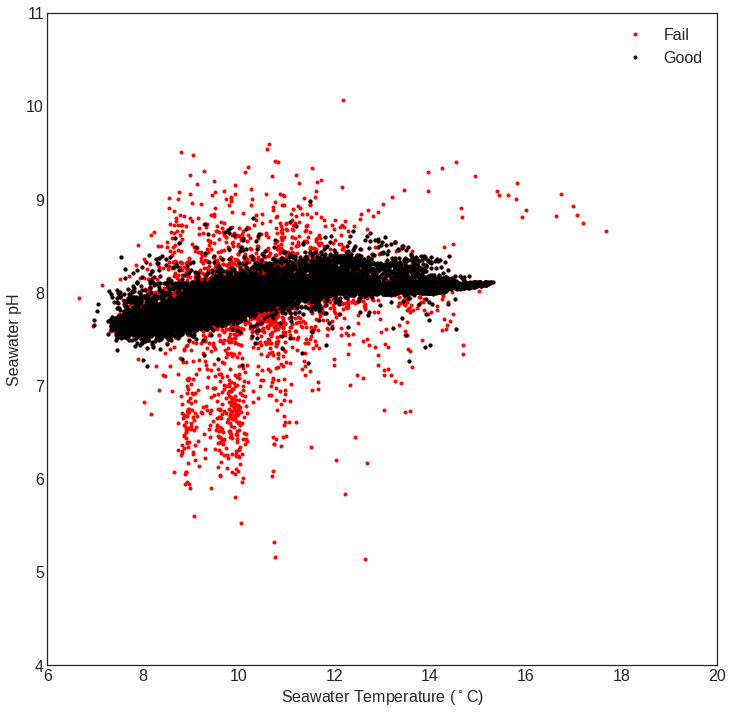

In [21]:
# plot the seawater pH as a function of temperature, again highlighting the "fail" data
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 16})
plt.plot(merged['thermistor_temperature'], merged['seawater_ph'], '.r', label='Fail')
plt.plot(good['thermistor_temperature'], good['seawater_ph'], '.k', label='Good')
plt.xlabel('Seawater Temperature ($^\circ$C)')
plt.ylabel('Seawater pH')
plt.ylim(4, 11)
plt.xlim(6, 20)
plt.legend()

If we eliminate the failed data from further consideration, and take a different look at the plot above (using the month of the year to color the points), an interesting pattern starts to emerge from the noisiness above.

(7.0, 9.0)

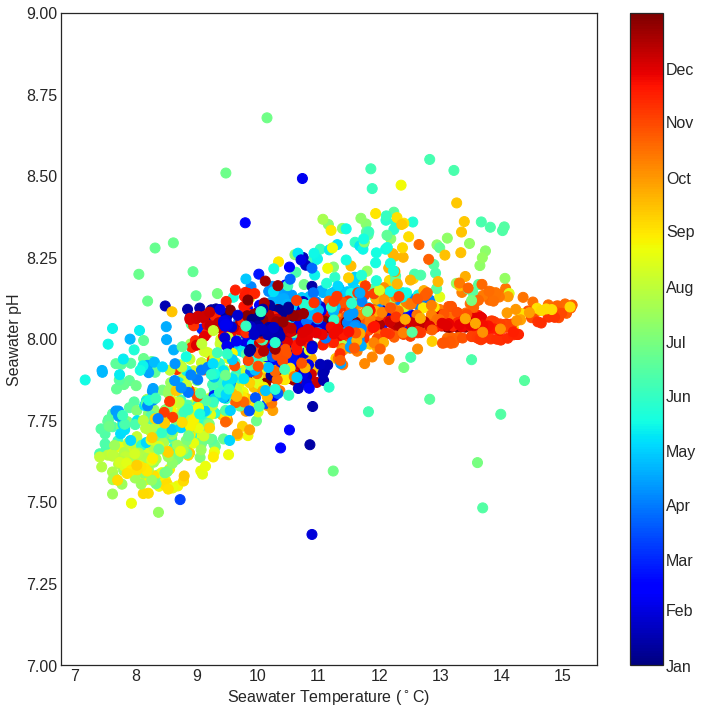

In [22]:
# plot the "good" seawater pH as a function of temperature, converted to daily, median averages.
# plus, let's see if we can tease out any seasonality to the temperature/pH relationship
daily = good.resample(time='D').median()
doy = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
cmnth = ['Jan', 'Feb', 'Mar', 'Apr', 
        'May', 'Jun', 'Jul', 'Aug',
        'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 16})
plt.scatter(daily['thermistor_temperature'], daily['seawater_ph'], c=daily['time'].dt.dayofyear, s=100, cmap='jet')
cbar = plt.colorbar()
cbar.set_ticks(doy)
cbar.set_ticklabels(cmnth)
plt.xlabel('Seawater Temperature ($^\circ$C)')
plt.ylabel('Seawater pH')
plt.ylim(7, 9)

In addition to cleaning up the data for scientific use, we can also use the cleaned up data to help generate values for the QARTOD gross range and climatology tests OOI is in the process of implementing. The gross range test uses a fail_span value set from the vendor documentation and a suspect_span value set from the mean of all of the data collected through 2021-01-01, plus/minus 3 standard deviations.  

In [24]:
# limit the time range and calculate the gross range values
good = good.sel(time=slice("2014-01-01T00:00:00", "2021-01-01T00:00:00"))
gr = process_gross_range(good, ['seawater_ph'], [6.9, 9.0], site=site, node=node, sensor=sensor)

In [27]:
print(gr.qcConfig.values)

[{'qartod': {'gross_range_test': {'suspect_span': ['7.45', '8.53'], 'fail_span': ['6.9', '9.0']}}}]


The climatology test uses a monthly range of data points, derived from a two-cycle harmonic fit to monthly means of the data plus/minus 3x the monthly standard deviations. These values are then saved to a table organized by the month.

In [28]:
# develop ranges for the QARTOD climatology test
clm, clm_table = process_climatology(good, ['seawater_ph'], [6.9, 9.0], site=site, node=node, sensor=sensor)

In [31]:
print(clm_table[0])

,[1, 1],[2, 2],[3, 3],[4, 4],[5, 5],[6, 6],[7, 7],[8, 8],[9, 9],[10, 10],[11, 11],[12, 12]
[0, 0],[7.81, 8.20],[7.67, 8.31],[7.67, 8.38],[7.73, 8.39],[7.40, 8.66],[7.19, 8.69],[7.13, 8.55],[7.22, 8.42],[7.21, 8.59],[7.72, 8.30],[7.86, 8.28],[7.84, 8.27]


To put this all together, so a user can see what the data looks like in the context of the QARTOD tests, we need to directly work with the climatology code, and do some re-arranging of the results...so...

In [33]:
import datetime
from ooi_data_explorations.qartod.climatology import Climatology
clm = Climatology()
clm.fit(good, 'seawater_ph')
clm.fitted_data.index = clm.fitted_data.index - datetime.timedelta(days=15)
clm.regression

{'beta': array([ 7.97948058, -0.08355157,  0.02498114,  0.05171126,  0.05460832,
         0.02880683, -0.01173664,  0.0108191 ,  0.01366966]),
 'residuals': array([0.38056947]),
 'rank': 9,
 'singular_values': array([8.24751036, 6.4756625 , 6.32984205, 5.85043888, 5.66731782,
        5.47722558, 5.36315383, 5.01505838, 4.97163067]),
 'variance_explained': array([0.5421713])}

In [36]:
std = np.append(clm.monthly_std.values[3:], clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values) 
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values[:1])

(6.5, 9.5)

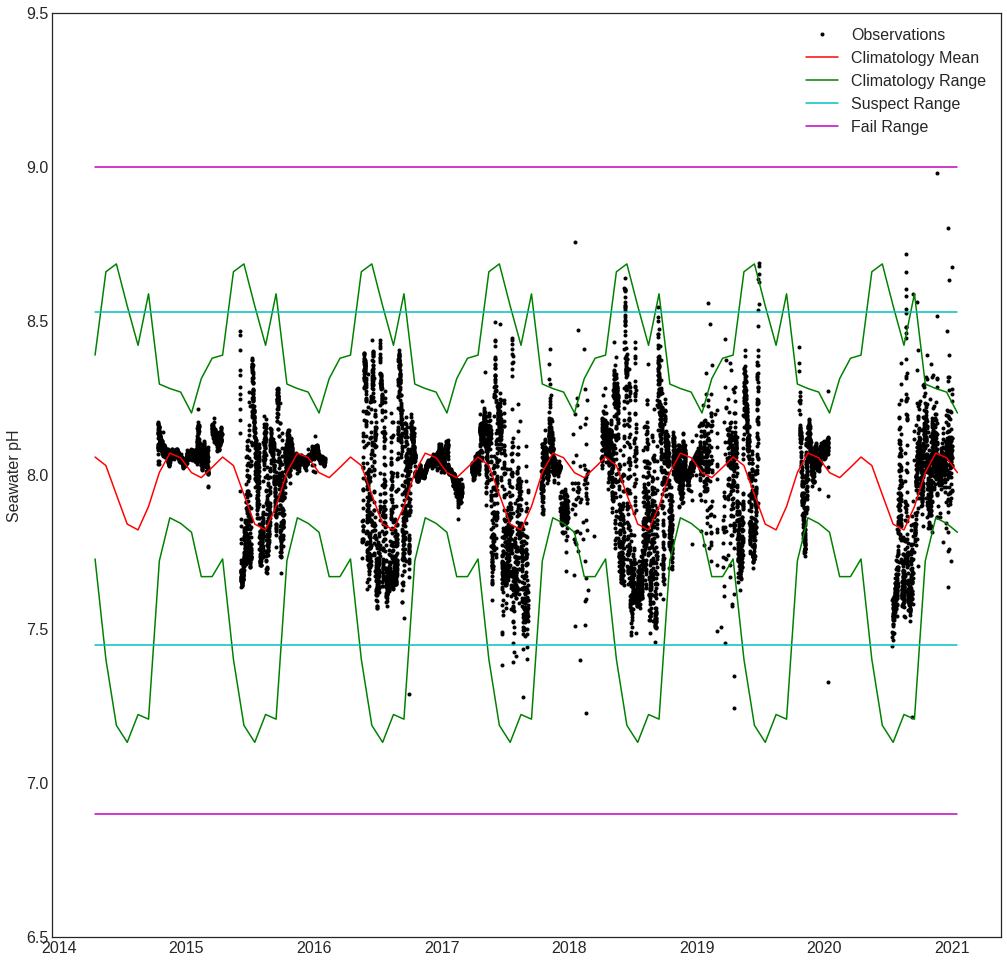

In [38]:
plt.figure(figsize=(17, 17))
plt.rcParams.update({'font.size': 16})
plt.plot(good['time'], good['seawater_ph'], '.k', label='Observations')
plt.plot(clm.fitted_data.index, clm.fitted_data.values, '-r', label='Climatology Mean')
plt.plot(clm.fitted_data.index, clm.fitted_data.values - 3 * std, '-g', label='Climatology Range')
plt.plot(clm.fitted_data.index, clm.fitted_data.values + 3 * std, '-g')
plt.plot(clm.fitted_data.index, np.repeat(7.45, 82), '-c', label='Suspect Range')
plt.plot(clm.fitted_data.index, np.repeat(8.53, 82), '-c')
plt.plot(clm.fitted_data.index, np.repeat(6.9, 82), '-m', label='Fail Range')
plt.plot(clm.fitted_data.index, np.repeat(9, 82), '-m')
plt.ylabel('Seawater pH')
plt.legend()
plt.ylim(6.5, 9.5)

In [42]:
# plot up the monthly means and the climatology fit to get a better understanding of the data and the 
# quality of the fit
mnthly = good.resample(time='M').mean()
grps = mnthly.groupby('time.month')

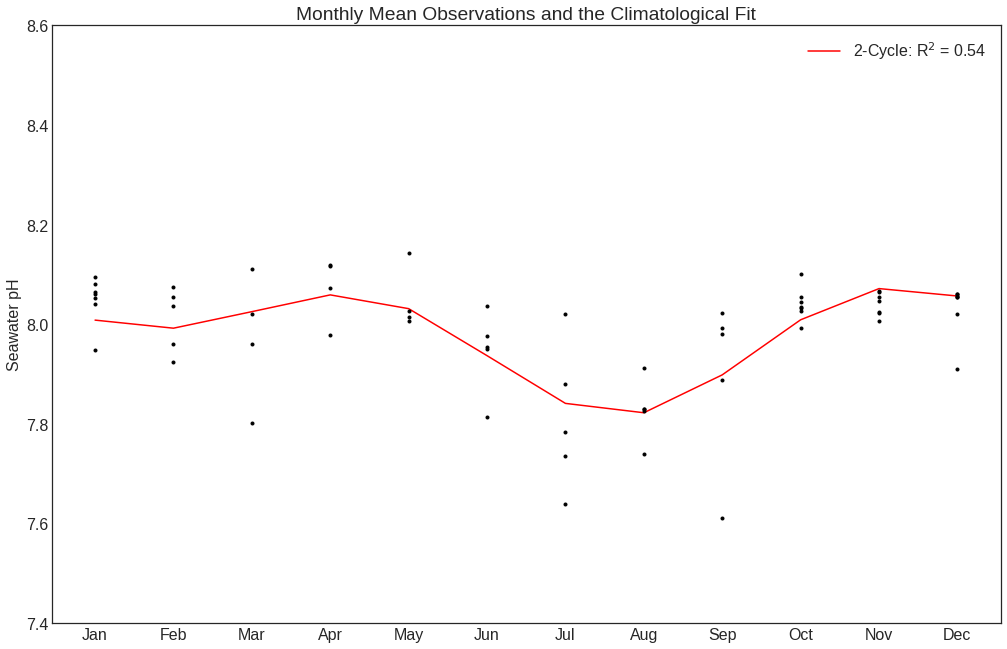

In [41]:
plt.figure(figsize=(17, 11))
plt.rcParams.update({'font.size': 16})
plt.plot(clm.monthly_fit.index, clm.monthly_fit.values, '-r', label='2-Cycle: R$^2$ = 0.54')
xtic = []
xlabel = []
for grp in grps:
    plt.plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['seawater_ph'], '.k')
    xtic.append(grp[1].time.to_index().strftime('%m').astype(int)[0])
    xlabel.append(grp[1].time.to_index().strftime('%b')[0])
plt.title('Monthly Mean Observations and the Climatological Fit')
plt.ylabel('Seawater pH')
plt.xticks(xtic, xlabel)
plt.ylim(7.4, 8.6)
plt.legend()